In [7]:
%pip install gymnasium
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt


In [31]:
import yfinance as yf
vgt_data = yf.download("VGT", start="2017-01-01", end="2023-04-30")
schd_data = yf.download("SCHD", start="2017-01-01", end="2023-04-30")


data = pd.concat([vgt_data, schd_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
split_index = int(len(data) * 0.8)

In [33]:
#TRAINING


window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
    'stocks-v0',
    df = data[:split_index],
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


In [34]:
#VALIDATION

window_size = 10
start_index = window_size
end_index = len(data)

val_env = gym.make(
    'stocks-v0',
    df = data[split_index:],
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([lambda : train_env, lambda : val_env])

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [49]:
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2138 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.53e+03    |
|    ep_rew_mean          | 136         |
| time/                   |             |
|    fps                  | 1499        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011826151 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 1.39e-05    |
|    learning_rate        | 0.0003      |
|    loss               

In [50]:
env = env
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': -136.92026901245117, 'total_profit': 0.0006849881883209703, 'position': 1}


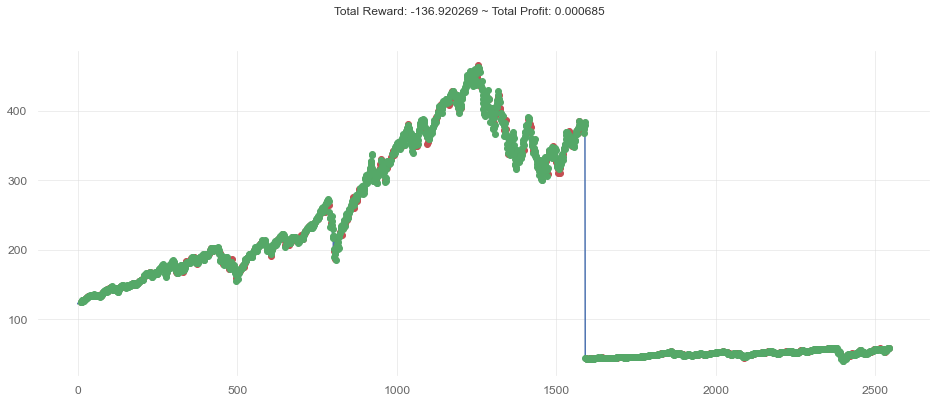

In [51]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

In [52]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

ValueError: Length of values (2534) does not match length of index (3171)